In [ ]:
from getpass import getpass

# Prompt for token securely
token = getpass('Enter your GitHub personal access token: ')

# Clone using token authentication
!git clone https://{token}@github.com/pabasara-samarakoon-4176/MDT_prediction.git

In [ ]:
!ls /content/MDT_prediction/

In [ ]:
!cp /content/drive/MyDrive/Colab\ Notebooks/synthetic_generation_full.ipynb /content/MDT_prediction/

In [ ]:
!ls /content/MDT_prediction/

In [ ]:
!git config --global user.email "pabasarasamarakoon2000@gmail.com"
!git config --global user.name "pabasara-samarakoon-4176"

In [ ]:
!cd /content/MDT_prediction && git add . && git commit -m "Add road coverage for synthetic generation notebook." && git push

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [3]:
filename = '/content/drive/MyDrive/Final_year_project/datasets/synthetic_v3.csv'
df = pd.read_csv(filename)
df.head()

,Cell_ID,RSRP,RSRQ,EARFCN_DL,Latitude_of_MDT,Longitude_of_MDT,Antenna Height,Azimuth,Tilt,Latitude_of_Site,Longitude_of_Site,Geometry,Geohash,building_count,total_road_length,elevation,slope,NDVI
0,CELL_1000,-114.624395,-10.618715,3750,5.979031,79.996395,44.484713,189.846087,7.273446,5.978958,79.996402,POINT (79.99639502845126 5.979030736102928),tc0fh27,0,0,0.0,0.0,0.860014
1,CELL_1000,-99.606300,-10.830562,3750,5.979569,79.997740,44.484713,189.846087,7.273446,5.978958,79.996402,POINT (79.99774041931212 5.97956903498132),tc0fh2s,0,0,0.0,0.0,0.860014
2,CELL_1000,-94.655705,-7.589006,3750,5.977997,79.993567,44.484713,189.846087,7.273446,5.978958,79.996402,POINT (79.99356655485387 5.977996665827369),tc0fh23,0,0,0.0,0.0,0.050004
3,CELL_1000,-92.516832,-11.616132,3750,5.977406,79.997332,44.484713,189.846087,7.273446,5.978958,79.996402,POINT (79.99733201545884 5.977406255267217),tc0fh2h,0,0,0.0,0.0,0.920012
4,CELL_1000,-82.716518,-7.374246,3750,5.978395,79.997316,44.484713,189.846087,7.273446,5.978958,79.996402,POINT (79.99731644022849 5.9783949725457095),tc0fh2k,0,0,0.0,0.0,0.920012


In [4]:
df['Cell_ID'].value_counts().mean()

np.float64(113.1755)

In [5]:
# use sequence length 128

In [6]:
df.shape

(226351, 18)

In [7]:
df.columns

Index(['Cell_ID', 'RSRP', 'RSRQ', 'EARFCN_DL', 'Latitude_of_MDT',
       'Longitude_of_MDT', 'Antenna Height', 'Azimuth', 'Tilt',
       'Latitude_of_Site', 'Longitude_of_Site', 'Geometry', 'Geohash',
       'building_count', 'total_road_length', 'elevation', 'slope', 'NDVI'],
      dtype='object')

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

In [9]:
unique_cells = df["Cell_ID"].unique()
np.random.seed(42)
np.random.shuffle(unique_cells)

In [10]:
train_frac = 0.7
val_frac = 0.15
test_frac = 0.15

n_total = len(unique_cells)
n_train = int(n_total * train_frac)
n_val = int(n_total * val_frac)

train_cells = unique_cells[:n_train]
val_cells = unique_cells[n_train:n_train + n_val]
test_cells = unique_cells[n_train + n_val:]

train_df = df[df["Cell_ID"].isin(train_cells)].reset_index(drop=True)
val_df = df[df["Cell_ID"].isin(val_cells)].reset_index(drop=True)
test_df = df[df["Cell_ID"].isin(test_cells)].reset_index(drop=True)

print(f"Train: {train_df.shape}, Val: {val_df.shape}, Test: {test_df.shape}")

Train: (160575, 18), Val: (32619, 18), Test: (33157, 18)


In [11]:
from sklearn.preprocessing import LabelEncoder

# Encode Geohash
le = LabelEncoder()
train_df['Geohash'] = le.fit_transform(train_df['Geohash'])
val_df['Geohash'] = le.fit_transform(val_df['Geohash'])
test_df['Geohash'] = le.fit_transform(test_df['Geohash'])

In [12]:
val_df.head()

,Cell_ID,RSRP,RSRQ,EARFCN_DL,Latitude_of_MDT,Longitude_of_MDT,Antenna Height,Azimuth,Tilt,Latitude_of_Site,Longitude_of_Site,Geometry,Geohash,building_count,total_road_length,elevation,slope,NDVI
0,CELL_1004,-64.378023,-5.749042,525,9.140536,81.234073,70.743318,193.509784,4.149178,9.121902,81.233687,POINT (81.23407347759328 9.140535830228734),14067,0,0,0.0,0.0,1.0
1,CELL_1004,-46.267951,-14.799091,525,9.122017,81.233411,70.743318,193.509784,4.149178,9.121902,81.233687,POINT (81.23341053727127 9.122016715323424),14036,0,0,0.0,0.0,1.0
2,CELL_1004,-125.002856,-10.484974,525,9.119593,81.232599,70.743318,193.509784,4.149178,9.121902,81.233687,POINT (81.23259889964378 9.119593078231986),14000,0,0,0.0,0.0,1.0
3,CELL_1004,-135.105375,-8.870339,525,9.115717,81.238946,70.743318,193.509784,4.149178,9.121902,81.233687,POINT (81.23894562723909 9.115717224624161),13976,0,0,0.0,0.0,1.0
4,CELL_1004,-32.617188,-12.417348,525,9.114456,81.236702,70.743318,193.509784,4.149178,9.121902,81.233687,POINT (81.23670227640093 9.114456106740874),13972,0,0,0.0,0.0,1.0


In [13]:
features = ['EARFCN_DL', 'Antenna Height', 'Azimuth', 'Tilt',
            'Latitude_of_Site', 'Longitude_of_Site', 'building_count',
            'total_road_length', 'elevation', 'slope', 'NDVI']

positional_encoding = ['Geohash']

target = ['RSRP', 'RSRQ']

In [14]:
feature_scalers = {}
for col in features:
    scaler = StandardScaler()
    train_df[f"{col}"] = scaler.fit_transform(train_df[[col]])
    val_df[f"{col}"] = scaler.fit_transform(val_df[[col]])
    test_df[f"{col}"] = scaler.fit_transform(test_df[[col]])
    feature_scalers[col] = scaler

In [15]:
target_scalers = {}
for col in target:
    scaler = StandardScaler()
    train_df[f"{col}"] = scaler.fit_transform(train_df[[col]])
    val_df[f"{col}"] = scaler.fit_transform(val_df[[col]])
    test_df[f"{col}"] = scaler.fit_transform(test_df[[col]])
    target_scalers[col] = scaler

In [16]:
test_df.head()

,Cell_ID,RSRP,RSRQ,EARFCN_DL,Latitude_of_MDT,Longitude_of_MDT,Antenna Height,Azimuth,Tilt,Latitude_of_Site,Longitude_of_Site,Geometry,Geohash,building_count,total_road_length,elevation,slope,NDVI
0,CELL_1001,-1.754428,-0.631321,-1.171933,6.727346,80.013779,-0.097179,-1.204016,0.01764,-0.937295,-1.390665,POINT (80.01377888928732 6.727346433086757),539,8.859010,0.014138,-0.375578,-0.375869,0.387072
1,CELL_1001,-0.086678,0.830847,-1.171933,6.728332,79.989820,-0.097179,-1.204016,0.01764,-0.937295,-1.390665,POINT (79.98981986555145 6.728332492740996),533,3.413101,-0.091813,-0.384155,-0.394201,-1.796744
2,CELL_1001,-0.119889,1.164123,-1.171933,6.742484,79.988824,-0.097179,-1.204016,0.01764,-0.937295,-1.390665,POINT (79.9888239460641 6.742484011107237),537,0.871676,-0.091813,-0.424076,-0.413616,-1.796744
3,CELL_1001,-1.343247,-0.143965,-1.171933,6.719888,80.017566,-0.097179,-1.204016,0.01764,-0.937295,-1.390665,POINT (80.01756562229868 6.719888383226705),531,1.234737,-0.091813,-0.444731,-0.439200,-1.646142
4,CELL_1001,1.618485,0.256477,-1.171933,6.726213,79.988746,-0.097179,-1.204016,0.01764,-0.937295,-1.390665,POINT (79.98874573016573 6.726213295195135),532,4.139222,-0.091813,-0.400341,-0.428625,-1.796744


In [17]:
def prepare_sequence_tensor(df, seq_len, feature_cols, pos_cols, target_cols):
    N = (len(df) // seq_len) * seq_len
    df = df.iloc[:N]

    num_seq = N // seq_len
    input_tensor = torch.tensor(df[feature_cols].values, dtype=torch.float32).view(num_seq, seq_len, -1)
    pos_tensor = torch.tensor(df[pos_cols].values, dtype=torch.float32).view(num_seq, seq_len, -1)
    target_tensor = torch.tensor(df[target_cols].values, dtype=torch.float32).view(num_seq, seq_len, -1)
    return input_tensor, pos_tensor, target_tensor

In [48]:
sequence_length = 256

In [49]:
X_train, pos_train, y_train = prepare_sequence_tensor(train_df, sequence_length, features, positional_encoding, target)
X_val, pos_val, y_val = prepare_sequence_tensor(val_df, sequence_length, features, positional_encoding, target)
X_test, pos_test, y_test = prepare_sequence_tensor(test_df, sequence_length, features, positional_encoding, target)

In [50]:
X_train.shape

torch.Size([627, 256, 11])

In [51]:
pos_train.shape

torch.Size([627, 256, 1])

In [52]:
y_train.shape

torch.Size([627, 256, 2])

In [53]:
batch_size = 32

In [54]:
train_loader = DataLoader(TensorDataset(X_train, pos_train, y_train), batch_size=batch_size)
val_loader = DataLoader(TensorDataset(X_val, pos_val, y_val), batch_size=batch_size)
test_loader = DataLoader(TensorDataset(X_test, pos_test, y_test), batch_size=batch_size)

In [55]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        self.num_heads = num_heads
        self.d_k = d_model // num_heads
        self.qkv_proj = nn.Linear(d_model, d_model * 3)
        self.out_proj = nn.Linear(d_model, d_model)

    def forward(self, x):
        B, S, D = x.shape
        qkv = self.qkv_proj(x).reshape(B, S, self.num_heads, 3 * self.d_k).transpose(1, 2)
        Q, K, V = qkv.chunk(3, dim=-1)
        scores = Q @ K.transpose(-2, -1) / np.sqrt(self.d_k)
        attn = F.softmax(scores, dim=-1)
        context = attn @ V
        context = context.transpose(1, 2).reshape(B, S, D)
        return self.out_proj(context)

In [56]:
class TransformerBlock(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()
        self.attn = MultiHeadAttention(d_model, num_heads)
        self.norm1 = nn.LayerNorm(d_model)
        self.ff = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Linear(d_ff, d_model)
        )
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.norm1(x + self.dropout(self.attn(x)))
        return self.norm2(x + self.dropout(self.ff(x)))

In [75]:
class TransformerModel(nn.Module):
    def __init__(self, input_dim, output_dim, d_model=128, num_heads=16, num_layers=20, d_ff=256):
        super().__init__()
        self.input_proj = nn.Linear(input_dim, d_model)
        self.pos_proj = nn.Linear(1, d_model)
        self.layers = nn.ModuleList([
            TransformerBlock(d_model, num_heads, d_ff) for _ in range(num_layers)
        ])
        self.output_layer = nn.Linear(d_model, output_dim)

    def forward(self, x, pos):
        x = self.input_proj(x) + self.pos_proj(pos)
        for layer in self.layers:
            x = layer(x)
        return self.output_layer(x)

In [76]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [77]:
model = TransformerModel(input_dim=len(features), output_dim=len(target)).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [78]:
epochs = 10
train_losses = []
val_losses = []

In [79]:
for epoch in range(1, epochs + 1):
    model.train()
    train_loss = 0
    for xb, pb, yb in train_loader:
        xb, pb, yb = xb.to(device), pb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb, pb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb, pb, yb in val_loader:
            xb, pb, yb = xb.to(device), pb.to(device), yb.to(device)
            preds = model(xb, pb)
            loss = criterion(preds, yb)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch [{epoch}/{epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

Epoch [1/10], Train Loss: 1.6389, Val Loss: 1.0000
Epoch [2/10], Train Loss: 1.0110, Val Loss: 1.0010
Epoch [3/10], Train Loss: 1.0079, Val Loss: 0.9997
Epoch [4/10], Train Loss: 1.0066, Val Loss: 0.9997
Epoch [5/10], Train Loss: 1.0063, Val Loss: 0.9997
Epoch [6/10], Train Loss: 1.0051, Val Loss: 0.9999
Epoch [7/10], Train Loss: 1.0047, Val Loss: 0.9998
Epoch [8/10], Train Loss: 1.0043, Val Loss: 0.9999
Epoch [9/10], Train Loss: 1.0038, Val Loss: 1.0001
Epoch [10/10], Train Loss: 1.0029, Val Loss: 1.0003


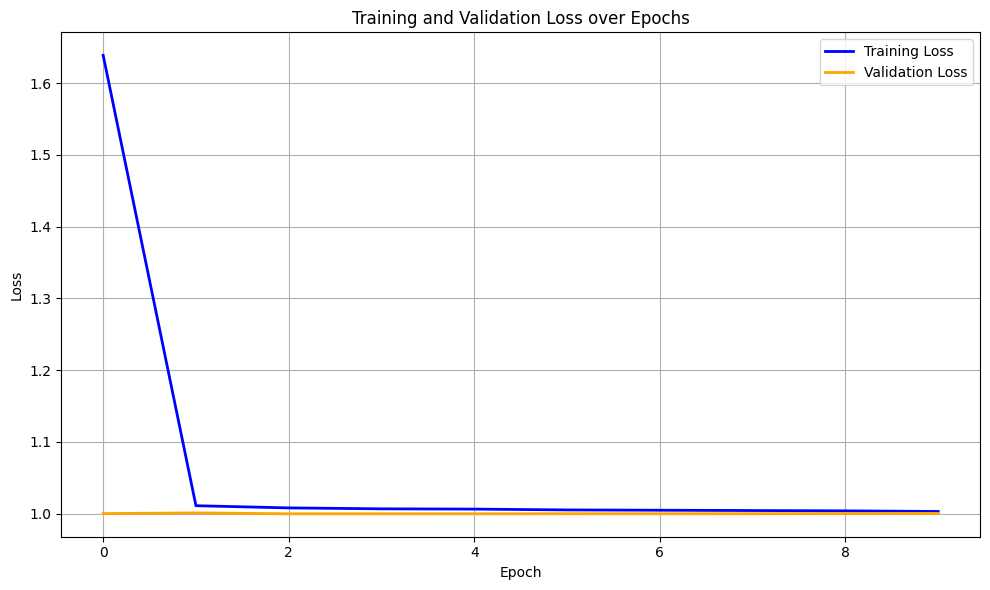

In [80]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss', color='blue', linewidth=2)
plt.plot(val_losses, label='Validation Loss', color='orange', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [81]:
# Epoch [20/20], Train Loss: 0.9802, Val Loss: 0.9779
# Epoch [100/100], Train Loss: 0.8990, Val Loss: 1.0404

In [82]:
model.eval()
X_test = X_test.to(device)
pos_test = pos_test.to(device)
y_test = y_test.to(device)

In [83]:
X_test.shape

torch.Size([129, 256, 11])

In [84]:
pos_test.shape

torch.Size([129, 256, 1])

In [85]:
y_test.shape

torch.Size([129, 256, 2])

In [86]:
torch.zeros(y_test.shape[-1])

tensor([0., 0.])

In [91]:
model.eval()
criterion = nn.MSELoss(reduction='mean')
total_loss = 0
per_target_loss = torch.zeros(y_test.shape[-1])

In [92]:
with torch.no_grad():
    predictions = model(X_test, pos_test)

In [93]:
predictions.shape

torch.Size([129, 256, 2])

In [95]:
with torch.no_grad():
    predictions = model(X_test, pos_test)
    if predictions.shape[-1] == 1 and y_test.shape[-1] > 1:
        raise ValueError("Model output is single-valued, but multiple targets are expected.")

    if predictions.shape[-1] == 1:
        predictions = predictions.squeeze(-1)
        y_test = y_test.squeeze(-1)
        total_loss = criterion(predictions, y_test)
        print(f"Test Loss: {total_loss.item():.4f}")

    for i in range(y_test.shape[-1]):
        loss = criterion(predictions[:, :, i], y_test[:, :, i])
        per_target_loss[i] = loss

    print(f"Per-Target Loss: {per_target_loss.tolist()}")
    for i in range(y_test.shape[-1]):
        name = target[i] if target else f"Target {i+1}"
        print(f"{name}: {per_target_loss[i].item():.4f}")

    print(f"\nAverage Test Loss: {per_target_loss.mean().item():.4f}")

Per-Target Loss: [1.0011714696884155, 1.000315546989441]
RSRP: 1.0012
RSRQ: 1.0003

Average Test Loss: 1.0007


In [99]:
preds_np = predictions.detach().cpu().numpy().reshape(-1, preds.shape[-1])
X_flat = X_test.reshape(-1, X_test.shape[-1]).cpu().numpy()
pos_flat = pos_test.reshape(-1, pos_test.shape[-1]).cpu().numpy()

In [104]:
features_df = pd.DataFrame(X_flat, columns=features)
pos_df = pd.DataFrame(pos_flat, columns=positional_encoding)
preds_df = pd.DataFrame(preds_np, columns=[f'{col}' for col in target])

In [105]:
predicted_df = pd.concat([features_df, pos_df, preds_df], axis=1)
predicted_df.head()

,EARFCN_DL,Antenna Height,Azimuth,Tilt,Latitude_of_Site,Longitude_of_Site,building_count,total_road_length,elevation,slope,NDVI,Geohash,RSRP,RSRQ
0,-1.171933,-0.097179,-1.204016,0.01764,-0.937295,-1.390665,8.859011,0.014138,-0.375578,-0.375869,0.387072,539.0,-0.032784,0.018798
1,-1.171933,-0.097179,-1.204016,0.01764,-0.937295,-1.390665,3.413101,-0.091813,-0.384155,-0.394201,-1.796744,533.0,-0.032784,0.018798
2,-1.171933,-0.097179,-1.204016,0.01764,-0.937295,-1.390665,0.871676,-0.091813,-0.424076,-0.413616,-1.796744,537.0,-0.032784,0.018798
3,-1.171933,-0.097179,-1.204016,0.01764,-0.937295,-1.390665,1.234737,-0.091813,-0.444731,-0.439200,-1.646142,531.0,-0.032784,0.018798
4,-1.171933,-0.097179,-1.204016,0.01764,-0.937295,-1.390665,4.139222,-0.091813,-0.400341,-0.428625,-1.796744,532.0,-0.032784,0.018798


In [106]:
predicted_df['Geohash'] = predicted_df['Geohash'].astype(int)
predicted_df.head()

,EARFCN_DL,Antenna Height,Azimuth,Tilt,Latitude_of_Site,Longitude_of_Site,building_count,total_road_length,elevation,slope,NDVI,Geohash,RSRP,RSRQ
0,-1.171933,-0.097179,-1.204016,0.01764,-0.937295,-1.390665,8.859011,0.014138,-0.375578,-0.375869,0.387072,539,-0.032784,0.018798
1,-1.171933,-0.097179,-1.204016,0.01764,-0.937295,-1.390665,3.413101,-0.091813,-0.384155,-0.394201,-1.796744,533,-0.032784,0.018798
2,-1.171933,-0.097179,-1.204016,0.01764,-0.937295,-1.390665,0.871676,-0.091813,-0.424076,-0.413616,-1.796744,537,-0.032784,0.018798
3,-1.171933,-0.097179,-1.204016,0.01764,-0.937295,-1.390665,1.234737,-0.091813,-0.444731,-0.439200,-1.646142,531,-0.032784,0.018798
4,-1.171933,-0.097179,-1.204016,0.01764,-0.937295,-1.390665,4.139222,-0.091813,-0.400341,-0.428625,-1.796744,532,-0.032784,0.018798


In [107]:
geohash_to_cell = test_df[['Geohash', 'Cell_ID']].drop_duplicates()

In [109]:
predicted_df = predicted_df.merge(geohash_to_cell, on='Geohash', how='left')
predicted_df.head()

,EARFCN_DL,Antenna Height,Azimuth,Tilt,Latitude_of_Site,Longitude_of_Site,building_count,total_road_length,elevation,slope,NDVI,Geohash,RSRP,RSRQ,Cell_ID
0,-1.171933,-0.097179,-1.204016,0.01764,-0.937295,-1.390665,8.859011,0.014138,-0.375578,-0.375869,0.387072,539,-0.032784,0.018798,CELL_1001
1,-1.171933,-0.097179,-1.204016,0.01764,-0.937295,-1.390665,3.413101,-0.091813,-0.384155,-0.394201,-1.796744,533,-0.032784,0.018798,CELL_1001
2,-1.171933,-0.097179,-1.204016,0.01764,-0.937295,-1.390665,0.871676,-0.091813,-0.424076,-0.413616,-1.796744,537,-0.032784,0.018798,CELL_1001
3,-1.171933,-0.097179,-1.204016,0.01764,-0.937295,-1.390665,1.234737,-0.091813,-0.444731,-0.439200,-1.646142,531,-0.032784,0.018798,CELL_1001
4,-1.171933,-0.097179,-1.204016,0.01764,-0.937295,-1.390665,4.139222,-0.091813,-0.400341,-0.428625,-1.796744,532,-0.032784,0.018798,CELL_1001


In [111]:
test_df = test_df.drop(columns=['Geometry'])

In [112]:
test_df.head()

,Cell_ID,RSRP,RSRQ,EARFCN_DL,Latitude_of_MDT,Longitude_of_MDT,Antenna Height,Azimuth,Tilt,Latitude_of_Site,Longitude_of_Site,Geohash,building_count,total_road_length,elevation,slope,NDVI
0,CELL_1001,-1.754428,-0.631321,-1.171933,6.727346,80.013779,-0.097179,-1.204016,0.01764,-0.937295,-1.390665,539,8.859010,0.014138,-0.375578,-0.375869,0.387072
1,CELL_1001,-0.086678,0.830847,-1.171933,6.728332,79.989820,-0.097179,-1.204016,0.01764,-0.937295,-1.390665,533,3.413101,-0.091813,-0.384155,-0.394201,-1.796744
2,CELL_1001,-0.119889,1.164123,-1.171933,6.742484,79.988824,-0.097179,-1.204016,0.01764,-0.937295,-1.390665,537,0.871676,-0.091813,-0.424076,-0.413616,-1.796744
3,CELL_1001,-1.343247,-0.143965,-1.171933,6.719888,80.017566,-0.097179,-1.204016,0.01764,-0.937295,-1.390665,531,1.234737,-0.091813,-0.444731,-0.439200,-1.646142
4,CELL_1001,1.618485,0.256477,-1.171933,6.726213,79.988746,-0.097179,-1.204016,0.01764,-0.937295,-1.390665,532,4.139222,-0.091813,-0.400341,-0.428625,-1.796744
